<a href="https://colab.research.google.com/github/andreidore/speed-speed-challenge/blob/master/speed_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm

In [2]:
import os
import numpy as np
import pandas as pd
import collections
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.layers import Input,Dense, Flatten, Concatenate,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

In [3]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU ",tf.config.list_physical_devices('GPU'))


TF version: 2.3.0
Hub version: 0.8.0
GPU  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
IMAGE_SIZE=224
STEP_FRAME=4

In [5]:
%rm -rf speedchallenge/

In [6]:
!wget https://github.com/commaai/speedchallenge/raw/master/data/train.mp4
!wget https://github.com/commaai/speedchallenge/raw/master/data/test.mp4
!wget https://github.com/commaai/speedchallenge/raw/master/data/train.txt

--2020-08-17 20:44:48--  https://github.com/commaai/speedchallenge/raw/master/data/train.mp4
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/commaai/speedchallenge/master/data/train.mp4 [following]
--2020-08-17 20:44:49--  https://media.githubusercontent.com/media/commaai/speedchallenge/master/data/train.mp4
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130034541 (124M) [application/octet-stream]
Saving to: ‘train.mp4’

train.mp4           100%[===================>] 124.01M  73.0MB/s    in 1.7s    

2020-08-17 20:44:56 (73.0 MB/s) - ‘train.mp4’ saved [130034541/130034541]

--2020-08

In [7]:
def window_stack(a, stepsize=1, width=20):
    n = a.shape[0]
    rows=n
    #print(rows)
    return np.vstack( a[i:i+width]  for i in range(rows) if i+width<=n )



y_data=open("train.txt").readlines()
y=np.array([float(y) for y in y_data])
print(len(y))
print(y[0:10])

y=window_stack(y,width=STEP_FRAME)
y=y[:,-1]

print("y shape ",y.shape)



20400
[28.105569 28.105569 28.106527 28.130404 28.109243 28.088572 28.034211
 28.018491 27.986624 28.016352]
y shape  (20397,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [8]:
cap = cv2.VideoCapture("train.mp4")

X=[]
internal_list=collections.deque(maxlen=STEP_FRAME)
index=0
while(cap.isOpened()):

  if index % 1000 ==0:
     print(len(X))
  
  ret, frame = cap.read()

  if frame is None:
      break

  frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame=cv2.resize(frame,(IMAGE_SIZE,IMAGE_SIZE))
  
  internal_list.append(frame)

  if(len(internal_list)==STEP_FRAME):
    X.append([internal_list[0],internal_list[-1]])

  
    
                  
  index+=1

cap.release()


X=np.array(X)

X_0=X[:,0,:,:,:]
X_1=X[:,1,:,:,:]

print("X shape ",X.shape)
print("X_0 shape ",X_0.shape)
print("X_1 shape ",X_1.shape)



0
997
1997
2997
3997
4997
5997
6997
7997
8997
9997
10997
11997
12997
13997
14997
15997
16997
17997
18997
19997
X shape  (20397, 2, 224, 224, 3)
X_0 shape  (20397, 224, 224, 3)
X_1 shape  (20397, 224, 224, 3)


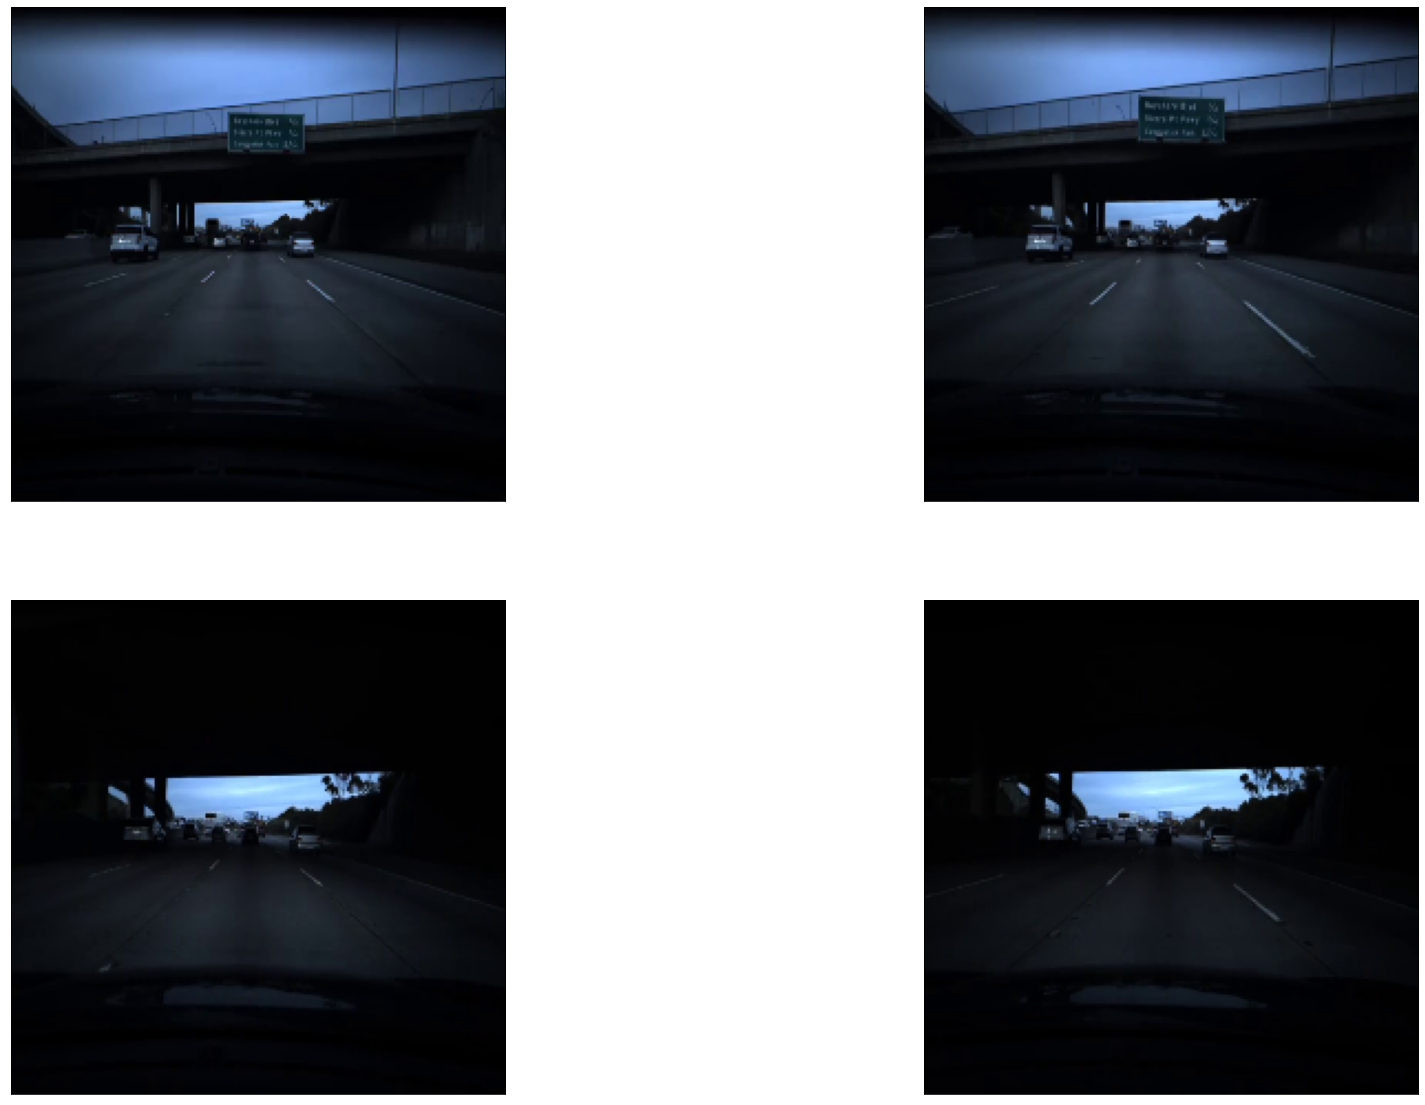

In [9]:
plt.figure(figsize=(30,20))
plt.subplot(221),plt.imshow(X_0[0]),plt.xticks([]), plt.yticks([])
plt.subplot(222) , plt.imshow(X_1[0]),plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(X_0[19]),plt.xticks([]), plt.yticks([])
plt.subplot(224) , plt.imshow(X_1[19]),plt.xticks([]), plt.yticks([])
plt.show()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 2048)         23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2048)         0           resnet50[0][0]        

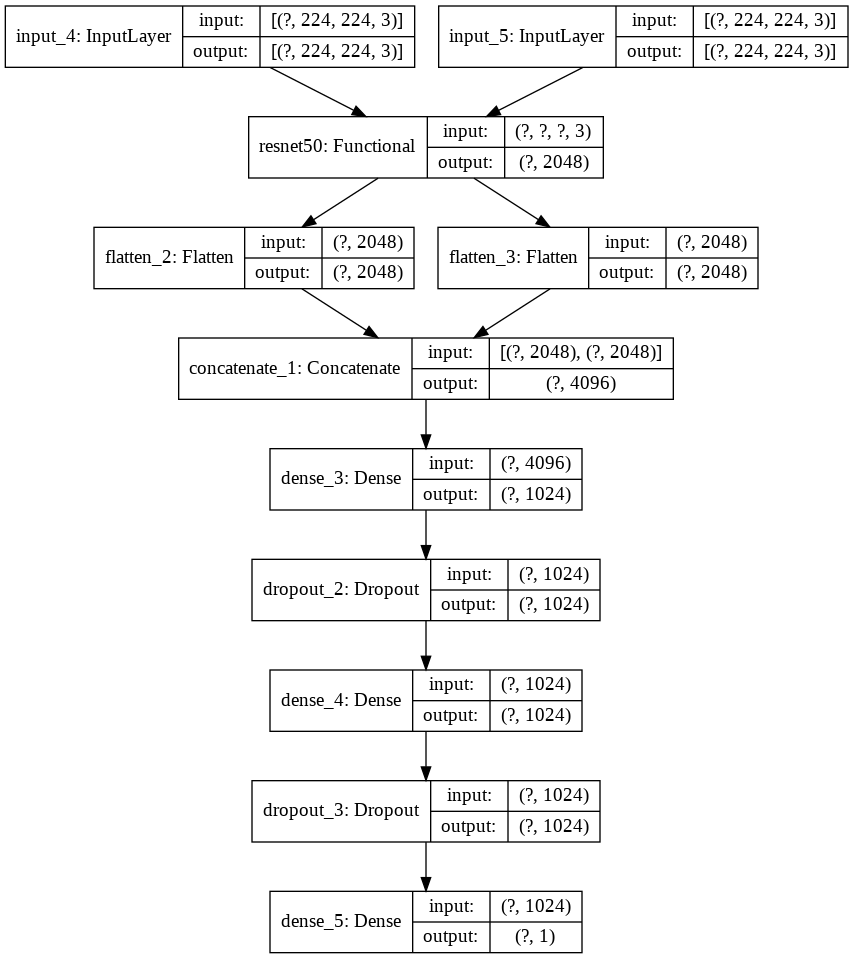

In [11]:

input_list=[Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)) for _ in range(2)]


resnet=ResNet50(include_top=False,pooling="avg")
resnet.trainable=True

resnet_list=[resnet(i) for i in input_list]

flat_list=[Flatten()(r) for r in resnet_list]


out=Concatenate()(flat_list)

net=Dense(1024,activation="relu")(out)
net=Dropout(0.25)(net)
net=Dense(1024,activation="relu")(net)
net=Dropout(0.25)(net)
net=Dense(1)(net)

model=Model(inputs=input_list,outputs=net)

model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)



In [12]:
reduce_callback= ReduceLROnPlateau(
                      monitor='val_loss', 
                       factor=.3,
                       patience=3,  
                       min_lr=1e-7) 

checkpoint_callback=ModelCheckpoint(filepath="best_model.hdf5",verbose=1,save_best_only=True)
early_stop_callback = EarlyStopping(monitor='val_loss',verbose=1,patience=7)




model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit([X_0,X_1],y,batch_size=64,epochs=100,verbose=1,validation_split=0.3,
          callbacks=[checkpoint_callback,reduce_callback,early_stop_callback])


Epoch 1/100
224/224 [==============================] - ETA: 0s - loss: 86.3881
Epoch 00001: val_loss improved from inf to 95.05474, saving model to best_model.hdf5
224/224 [==============================] - 155s 692ms/step - loss: 86.3881 - val_loss: 95.0547
Epoch 2/100
224/224 [==============================] - ETA: 0s - loss: 8.6558
Epoch 00002: val_loss improved from 95.05474 to 82.38501, saving model to best_model.hdf5
224/224 [==============================] - 152s 680ms/step - loss: 8.6558 - val_loss: 82.3850
Epoch 3/100
224/224 [==============================] - ETA: 0s - loss: 5.6658
Epoch 00003: val_loss improved from 82.38501 to 76.59258, saving model to best_model.hdf5
224/224 [==============================] - 152s 680ms/step - loss: 5.6658 - val_loss: 76.5926
Epoch 4/100
 11/224 [>.............................] - ETA: 1:56 - loss: 4.2296

KeyboardInterrupt: ignored